## Importing Libraries

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns 
import datetime as dt
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

C:\Users\ROSHAN\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv(r'C:\Users\ROSHAN\Documents\GitHub\extracting-tweets-forecasting-the-upcoming-elections-in-the-us\New Extraction\Data\Biden_No_Retweet_Full_Text.csv',error_bad_lines=False)

In [3]:
df.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,United States,Twitter for Android,0,54,192,0
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,United States,Twitter for iPhone,1,2476,3334,1
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15098 entries, 0 to 15097
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       15098 non-null  object
 1   Tweet_id   15098 non-null  int64 
 2   Verified   15098 non-null  bool  
 3   Tweet      15098 non-null  object
 4   User       15098 non-null  object
 5   Location   11032 non-null  object
 6   Source     15098 non-null  object
 7   Likes      15098 non-null  int64 
 8   Followers  15098 non-null  int64 
 9   Following  15098 non-null  int64 
 10  Retweets   15098 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 1.2+ MB


In [5]:
df.shape

(15098, 11)

# Data Preprocessing & Cleaning

The Date column is an object type. Let us convert it to datetime using datetime module.

In [6]:
df['Date'] = df['Date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #Convert to date time format

In [7]:
df.dtypes

Date         datetime64[ns]
Tweet_id              int64
Verified               bool
Tweet                object
User                 object
Location             object
Source               object
Likes                 int64
Followers             int64
Following             int64
Retweets              int64
dtype: object

Let us check for any null values in our dataset

In [8]:
df.isnull().sum()

Date            0
Tweet_id        0
Verified        0
Tweet           0
User            0
Location     4066
Source          0
Likes           0
Followers       0
Following       0
Retweets        0
dtype: int64

The location column has upto 4066 values as null. This may be the case since many users didn't voluntarily put it up. However this is not of much concern for our project. Hence we would leave it to null only

In [9]:
df['Source'].value_counts()

Twitter Web App                    5910
Twitter for iPhone                 4565
Twitter for Android                3267
Twitter for iPad                    705
TweetDeck                           150
                                   ... 
GlobalVillageSpace                    1
twitterBotAPaige                      1
Poshmark                              1
Ground News                           1
Falcon Social Media Management        1
Name: Source, Length: 87, dtype: int64

About 10,000 users tweeted from the web app & from iphone

In [10]:
df['Location'].nunique()

3200

Tweets gathered were from 3200 different locations around the world.

In [11]:
tweets_list = df['Tweet'].tolist()
len(tweets_list)

15098

In [12]:
tweets_list_updated = set(tweets_list)
len(tweets_list_updated)

15046

There seems to be some duplicates in our dataset. Let us remove these using the set function

In [13]:
tweets_list_updated  = list(tweets_list_updated)
type(tweets_list_updated)

list

In [14]:
df['Tweet'].duplicated().sum()

52

In [15]:
df = df.drop_duplicates(subset = 'Tweet', keep = 'first',ignore_index = True)
df.shape

(15046, 11)

Removed all the duplicates using the drop_duplicates function

In [16]:
df['Tweet'].duplicated().sum()

0

### Remove Emojis

In [17]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)



df['Processed_Tweet']=df.Tweet.apply(remove_emoji)


From now on, all the preprocessing & modelling on tweets will be stored in the data column called 'Processed_Tweet'

In [18]:
count = 0
for i in df['Processed_Tweet']:
    if re.match(r'^RT', i):  #remove any rows that contain RT
        df.drop(df.loc[df['Processed_Tweet']==i].index,inplace = True)
        count+=1
    
count

0

The above code is to ensure that there are no retweets in our dataset. Using Regex, this has been confirmed.

In [19]:
df.shape

(15046, 12)

In [20]:
df['Processed_Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

### Remove Retweets

In [21]:
df['Processed_Tweet'] = [re.sub('^RT[\s]','',i) for i in df['Processed_Tweet']]  #Remove RT substring

In [22]:
df['Processed_Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Remove Usernames

In [24]:
df['Processed_Tweet'] = [re.sub('@[^\s]+', ' ', i) for i in df['Processed_Tweet']] #remove usernames

In [25]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Remove Any URLs 

In [26]:
df['Processed_Tweet'] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', i) for i in df['Processed_Tweet']] #Remove urls

In [27]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Removing Hashtags & Keeping The Word

In [28]:
df['Processed_Tweet'] = [re.sub(r'#([^\s]+)', r'\1', i) for i in df['Processed_Tweet']] # remove the # in #hashtag

In [29]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        GeorgeWill , it’s so sad you wake up everyday ...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 Biden formally implicated in Ukrain...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls? Why Biden's 'Nationwide Lead' Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [30]:
import preprocessor as p #Module for faster preprocessing specifically for tweets

In [31]:
df['Processed_Tweet'] = [p.clean(i) for i in df['Processed_Tweet']]

In [32]:
df['Processed_Tweet']

0        VP Biden I wish you wouldn't debate Trump unle...
1        GeorgeWill , its so sad you wake up everyday f...
2        Question:If doesnt pick a woman of color, woul...
3        Right? Biden formally implicated in Ukraine sc...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls? Why Biden's 'Nationwide Lead' Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Removing Any Special Characters, Numbers, Punctuations etc.

In [33]:
#removing unnecessary special characters, numbers, punctuations in tweets
df.Processed_Tweet = df.Processed_Tweet.str.replace("[^a-zA-Z]", " ")


In [34]:
df["Processed_Tweet"]

0        VP Biden I wish you wouldn t debate Trump unle...
1        GeorgeWill   its so sad you wake up everyday f...
2        Question If doesnt pick a woman of color  woul...
3        Right  Biden formally implicated in Ukraine sc...
4        These idiots let Trump do anything he wants  W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don t want to leave out the left  Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls  Why Biden s  Nationwide Lead  Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [35]:
df.Processed_Tweet = [low.lower() for low in df.Processed_Tweet] #Converting into lower case 

In [36]:
df["Processed_Tweet"]

0        vp biden i wish you wouldn t debate trump unle...
1        georgewill   its so sad you wake up everyday f...
2        question if doesnt pick a woman of color  woul...
3        right  biden formally implicated in ukraine sc...
4        these idiots let trump do anything he wants  w...
                               ...                        
15041    other than going big by eulogizing stromthurmo...
15042    don t want to leave out the left  show your su...
15043    some chatter about biden maybe activating reso...
15044    fake polls  why biden s  nationwide lead  over...
15045    joe biden trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [37]:
df['Processed_Tweet'][12] #Sample tweet

'biden took know questions so he could tell you know lies  of course the lies would make absolutely no sense because he has no idea where he is or what hes doing  incontinent twit '

# EDA

In [38]:
df['User'].value_counts()

Hotpage_News       544
jacketrose86       174
mobygrapefan        71
defeatthedevil      67
deepen915           61
                  ... 
DepewRayd792002      1
jennabreit           1
m_mouse80            1
AnsonThePantsNJ      1
tlaino               1
Name: User, Length: 8270, dtype: int64

A whopping 544 tweets from Hotpage_News. This seems to be an account owned by an organization. Let us have a look at jacketrose86.

In [39]:
df.query('User == "jacketrose86"').Processed_Tweet.tolist()

['the can be no order when the laws remain unjust  trump s tyranny runs rampant while we die by the thousands   vote joe   liar  liar pants on fire  you re on the wrong side i d history  fk donniedollhands cheetomcasshat biden    landslide istandwithfauci fauciisahero biden',
 'it is our duty to protect the world from trump  we can t let him win another term  donniedollhands cheetomcasshat biden    landslide tangerinetyrant istandwithfauci fauciisahero biden trumpislosing trumpfailedamerica',
 'there are more reasons to not vote for him  staying alive is one of them  biden cares if we live or die   fk donniedollhands cheetomcasshat biden    landslide tangerinetyrant istandwithfauci fauciisahero biden trumpislosing trumpfailedamerica',
 'aww thanks for adding me fk donniedollhands cheetomcasshat biden    landslide tangerinetyrant istandwithfauci fauciisahero biden trumpislosing trumpfailedamerica',
 'thanks so much   have some snacks for cocktail hour  they re about the same size as his

A manual inspection clearly indicates a negative sentiment towards the candidature of Joe Biden

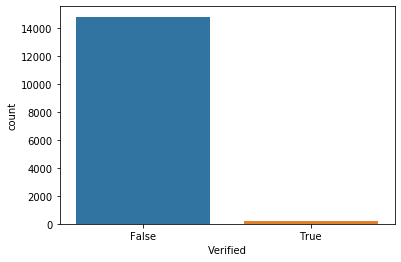

In [40]:
bar = sns.countplot(df['Verified'])

In [41]:
df['Verified'].value_counts()

False    14830
True       216
Name: Verified, dtype: int64

Only 216 verified accounts were extracted. This shouldn't be a problem while calculating our sentiment.

In [42]:
df_verified = df.query('Verified == True')
df_verified 

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet
116,2020-07-21 23:00:01,1285711153465683971,True,Judicial Watch announced it received records f...,JudicialWatch,"Washington, DC",TweetDeck,552,1738234,1924,327,judicial watch announced it received records f...
186,2020-07-21 22:21:56,1285701570932477952,True,Stay tuned folks. \n\n#Trump #KAG #KAG2020 🇺🇸🐘...,IamJohnBurnett,"New York, NY",Twitter Web App,3,15341,3102,1,stay tuned folks trump kag kag democrats ...
205,2020-07-21 22:14:26,1285699685982838786,True,Can #Trump overcome #Biden's lead in the polls...,IamJohnBurnett,"New York, NY",Twitter Web App,5,15341,3102,1,can trump overcome biden s lead in the polls ...
228,2020-07-21 22:05:17,1285697381275709441,True,Support #arts ! Open edition or limited editio...,annawilding,United States,Twitter Web App,2,1706,2015,0,support arts open edition or limited edition...
316,2020-07-21 21:15:04,1285684742617206784,True,Comment: 'Though #Biden talks about 'ending en...,The_NewArab,London,Hootsuite Inc.,2,88631,228,1,comment though biden talks about ending end...
...,...,...,...,...,...,...,...,...,...,...,...,...
14801,2020-07-13 14:58:33,1282690889668755458,True,The latest #FoxNews Poll shows Joe #Biden with...,Varneyco,New York,Twitter Web App,109,658176,729,41,the latest foxnews poll shows joe biden with a...
14913,2020-07-13 13:26:50,1282667808279670785,True,"Arctic at +100℉, record ice melts, devastating...",DemsAbroad,Worldwide!,Twitter for iPhone,3,18747,8730,0,arctic at record ice melts devastating ...
15005,2020-07-13 11:52:52,1282644156859518976,True,"@realDonaldTrump Yes, it is. Because @JoeBiden...",AndyOstroy,NYC,Twitter for iPhone,421,78928,3202,46,yes it is because is not an ignorant incomp...
15031,2020-07-13 11:25:41,1282637319783284736,True,Hey @realDonaldTrump...resign while you can be...,AndyOstroy,NYC,Twitter for iPhone,123,78928,3202,37,hey while you can before youre dealt the bigge...


In [43]:
df_verified['User'].value_counts()

AndyOstroy         15
JudicialWatch       9
Varneyco            7
DemsAbroad          7
The_NewArab         7
                   ..
TheDaveWeinbaum     1
IranIntl_En         1
robenfarzad         1
DrJasonJohnson      1
AWKWORDrap          1
Name: User, Length: 121, dtype: int64

A user by the name AndyOstroy has 15 tweets about Joe Biden in the time-period of extraction. Let us look at some of his tweets.

In [44]:
df_verified.query('User == "AndyOstroy"').Processed_Tweet.tolist()

['its intellectually dishonest  and quite hypocritical  for liberals who preach unity and bipartisanship to be losing their damn minds because one republican is gonna speak at the democratic convention    johnkasich kasich biden',
 'we are now at a new cray cray low in the trump presidency where he s challenged biden to a duel to see who can  ace  the  is this a lion or a monkey   cognitive test    chriswallace',
 'humiliating   historic    landslide  its coming     trump election     biden',
 'hey like how you cried daddy  daddy  please dont let them make me go to vietnam  before he bought you those deferments  coward    trump chriswallace biden',
 'how do you feel about susanrice as biden s vp ',
 'i believe on nov rd were going to witness the biggest  most humiliating  most historic backlash against and republicans this country has ever seen and could ever have imagined    election     biden trump',
 'hey moron   all of this darkness  despair  dysfunction  disease  death you re show

He seems to be very angry towards Joe Biden & clearly has no positive sentiment 

Let us look at another, JudicialWatch

In [45]:
df_verified.query('User == "JudicialWatch"').Processed_Tweet.tolist()

['judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the obama administration  hunter biden traveled extensively while receiving a secret service protective detail  read ',
 '  president  theres no lawful reason for the university of delaware to withhold biden records  read more at',
 ' judicial watch investigators uncovered records from the u s  secret service showing that  for the first and a half years of the obama admin  hunter biden traveled extensively with a secret service protective detail  in newsmax  read ',
 'judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the obama administration  hunter biden traveled extensively while receiving a secret service protective detail  read ',
 'judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the obama administration  hunter biden traveled extensi

On manual inspection, there seems to be sentiment towards Joe Biden. Can be classified as a Neutral user.

Let us observe the dates & how they fair out. Let us observe how many tweets were extracted on which date

In [46]:
days = df['Date'].dt.day.tolist()

In [47]:
no_of_days = Counter(days)
no_of_days

Counter({21: 2084,
         20: 1862,
         19: 1712,
         18: 1322,
         17: 1573,
         16: 1638,
         15: 2020,
         14: 1884,
         13: 951})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Day')

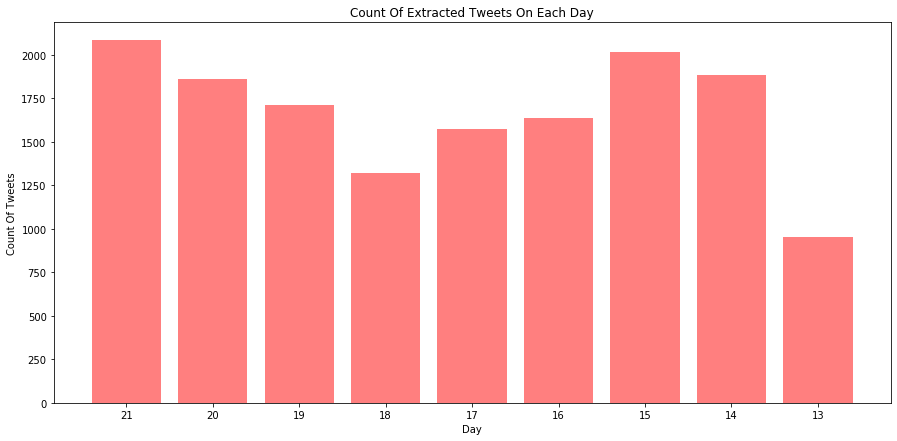

In [48]:
fig = plt.figure(figsize = (15,7))
plt.bar(range(len(no_of_days)), list(no_of_days.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_days)), list(no_of_days.keys()))
plt.xlabel("Day")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Day")

We had a maximum of approx 2000 tweets extracted on the 21st July & the 15th of July.

Let us also look at the times (hours) at which the most tweets were extracted.

In [49]:
hours = df['Date'].dt.hour.tolist()

In [50]:
no_of_hours = Counter(hours)
no_of_hours

Counter({23: 857,
         22: 917,
         21: 891,
         20: 829,
         19: 828,
         18: 1107,
         17: 938,
         16: 953,
         15: 867,
         14: 834,
         13: 740,
         12: 560,
         11: 423,
         10: 260,
         9: 156,
         8: 157,
         7: 198,
         6: 237,
         5: 290,
         4: 397,
         3: 475,
         2: 628,
         1: 780,
         0: 724})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Hour')

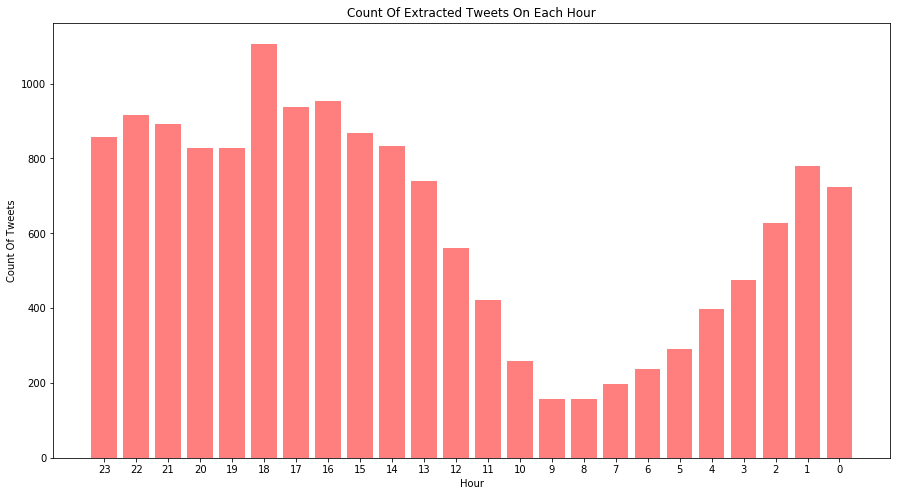

In [51]:
fig = plt.figure(figsize = (15,8))
plt.bar(range(len(no_of_hours)), list(no_of_hours.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_hours)), list(no_of_hours.keys()))
plt.xlabel("Hour")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Hour")

Lots of tweets at the 18:00 - 19:00 hour period followed by 16:00 - 17:00 hour

In [52]:
from wordcloud import WordCloud
tokenizer = TweetTokenizer()


We still have to remove stopwords, perform lemmatization & do stemming. So let us proceed with that

### Removing Stop Words

In [53]:
stop_words = set(stopwords.words('english')) 
stop_words = list(stop_words)
print(stop_words)

['up', 'when', 'wouldn', 'hadn', "doesn't", 'him', 'those', 'not', 'before', 'because', "you'd", 'will', 'just', 'weren', 'the', 'my', 'did', 'below', "didn't", 'i', 'itself', 'each', 'themselves', 'more', "she's", "won't", 'a', 'too', 'can', 'needn', "couldn't", 'only', 'but', 'yourselves', 'isn', 'for', 'he', 'with', 'm', 'be', 'who', 'so', 'same', 'now', 'you', "shouldn't", 'whom', 'what', 'over', 'y', 'between', 'shouldn', 'being', 'and', "hadn't", 'won', 'an', 'through', "hasn't", 'any', "needn't", 'our', 's', 'no', 'where', 'nor', 'few', 'd', 'having', 'out', 'in', 'their', 'yours', 'after', 'been', 'this', 'about', 'its', 'mightn', 'own', 'by', 'some', 'all', 'once', 'theirs', 'very', 'has', "shan't", 'during', 'as', 'didn', "isn't", 'his', 'further', 'aren', 'if', 'under', 'of', 'don', 'yourself', 'ourselves', 'to', 'how', "that'll", "should've", 'at', 'above', 'is', 'it', 'mustn', 'o', "mustn't", 'her', 'they', 'these', 'then', 'wasn', "wouldn't", 'them', 'am', 'ours', 'other'

In [54]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: ' '.join(w for w in x.split() if w not in stop_words))   #Remove stopwords

In [55]:
df['Processed_Tweet']

0        vp biden wish debate trump unless debate trump...
1        georgewill sad wake everyday forgetting george...
2        question doesnt pick woman color would black c...
3        right biden formally implicated ukraine scanda...
4        idiots let trump anything wants biden gets ele...
                               ...                        
15041    going big eulogizing stromthurmond look right ...
15042    want leave left show support election hearts f...
15043    chatter biden maybe activating resources fight...
15044    fake polls biden nationwide lead trump says no...
15045                   joe biden trump police armed teeth
Name: Processed_Tweet, Length: 15046, dtype: object

## Tokenizing

In [56]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: tokenizer.tokenize(x))

In [57]:
df['Processed_Tweet']

0        [vp, biden, wish, debate, trump, unless, debat...
1        [georgewill, sad, wake, everyday, forgetting, ...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formally, implicated, ukraine, ...
4        [idiots, let, trump, anything, wants, biden, g...
                               ...                        
15041    [going, big, eulogizing, stromthurmond, look, ...
15042    [want, leave, left, show, support, election, h...
15043    [chatter, biden, maybe, activating, resources,...
15044    [fake, polls, biden, nationwide, lead, trump, ...
15045            [joe, biden, trump, police, armed, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

## Stemming & Lemmatization

In [59]:
#Perform stemming & lemmatization
def lemmatize_stemming(text):
    stemmer=PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [60]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: [lemmatize_stemming(i) for i in x]) # stemming

In [61]:
df['Processed_Tweet']

0        [vp, biden, wish, debat, trump, unless, debat,...
1        [georgewil, sad, wake, everyday, forget, georg...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formal, implic, ukrain, scandal...
4        [idiot, let, trump, anyth, want, biden, get, e...
                               ...                        
15041    [go, big, eulog, stromthurmond, look, right, l...
15042    [want, leav, leav, show, support, elect, heart...
15043    [chatter, biden, mayb, activ, resourc, fight, ...
15044    [fake, poll, biden, nationwid, lead, trump, sa...
15045               [joe, biden, trump, polic, arm, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

In [62]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: [i for i in x if len(i)>2])

In [63]:
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,United States,Twitter for Android,0,54,192,0,"[biden, wish, debat, trump, unless, debat, tru..."
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0,"[georgewil, sad, wake, everyday, forget, georg..."
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0,"[question, doesnt, pick, woman, color, would, ..."
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,United States,Twitter for iPhone,1,2476,3334,1,"[right, biden, formal, implic, ukrain, scandal..."
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0,"[idiot, let, trump, anyth, want, biden, get, e..."
...,...,...,...,...,...,...,...,...,...,...,...,...
15041,2020-07-13 10:57:58,1282630342038499329,False,Other than going big by eulogizing #StromThurm...,robertson_alton,"Fort Worth, or thereabouts.",Twitter Web App,0,1004,4999,0,"[big, eulog, stromthurmond, look, right, look,..."
15042,2020-07-13 10:56:26,1282629958205145091,False,Don't want to leave out the left! Show your su...,GraphicMedia4,NaN,Twitter Web App,0,1,0,0,"[want, leav, leav, show, support, elect, heart..."
15043,2020-07-13 10:53:50,1282629302199164928,False,Some chatter about #Biden maybe activating res...,copiousjawnt,"Lehigh Valley, PA",Twitter for Android,0,84,210,0,"[chatter, biden, mayb, activ, resourc, fight, ..."
15044,2020-07-13 10:53:46,1282629284524433409,False,Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...,blinova14,NaN,Twitter Web App,4,836,432,0,"[fake, poll, biden, nationwid, lead, trump, sa..."


Creating strings for each tweet for putting in the model

In [64]:
texts = []
texts = df.Processed_Tweet.apply(lambda x: [i for i in x] )

In [65]:
all_words = []
for i in texts:
    all_words.append(" ".join(i))
    
all_words

['biden wish debat trump unless debat trump show taxesdeb tell putin stop kill soldiersdeb put sanction putin elect hack amp wish publicli challeng biden rice',
 'georgewil sad wake everyday forget georg elitist like swamper badli need disinfect your new breed senileelit man plan vote biden',
 'question doesnt pick woman color would black commun hold resist biden bidenrepublican',
 'right biden formal implic ukrain scandal report afternoon burisma',
 'idiot let trump anyth want biden get elect want hear word hope biden barack come like',
 'could biden ohio pennsylvania dont buy anyon electiontwitt buy',
 'never teach religion public school want watch biden pander islamdisgust peopl dumb christian countri peopl believ god outnumb non christian religion combin usabiden',
 'dream vote biden biden sweep hous senat presid biden novemb',
 'joy one woman mission expos none good fit potu happi put space time biden blacklivesmatt biden landslid',
 'sleep better obama biden joe biden make americ

In [66]:
text = []
for i in texts:
    for j in i:
        text.append(j)

In [67]:
len(text)

229218

In [68]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(text))

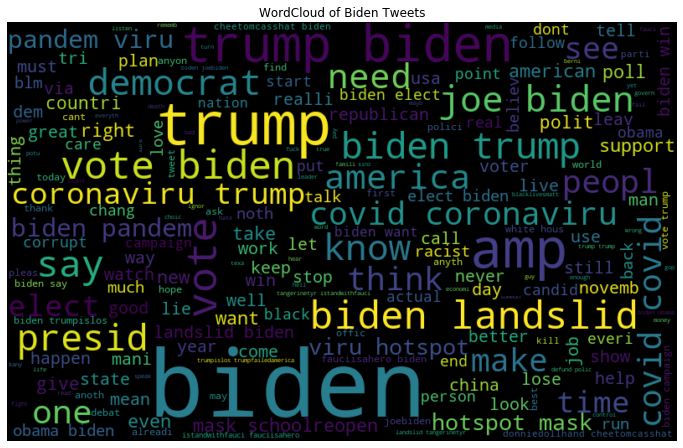

In [69]:
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud of Biden Tweets")
plt.show()

## Sentiment Analysis

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Defining the vectorizer 
vect = TfidfVectorizer(ngram_range=(1,1), max_features=100).fit(text)

# Transform the vectorizer
X_txt = vect.transform(text)

# Transforming to a data frame 
X=pd.DataFrame(X_txt.toarray(), columns=vect.get_feature_names())
X.head(10)

,america,american,amp,back,believ,better,biden,black,call,campaign,...,voter,want,watch,way,white,win,work,world,would,year
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
from textblob import TextBlob

In [72]:
pol=[]
for Tweet in all_words:
    blob = TextBlob(Tweet)
    pol.append(blob.sentiment.polarity)

In [73]:
len(pol)

15046

In [74]:
len(text)

229218

In [75]:
df['Processed_Tweet']

0        [biden, wish, debat, trump, unless, debat, tru...
1        [georgewil, sad, wake, everyday, forget, georg...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formal, implic, ukrain, scandal...
4        [idiot, let, trump, anyth, want, biden, get, e...
                               ...                        
15041    [big, eulog, stromthurmond, look, right, look,...
15042    [want, leav, leav, show, support, elect, heart...
15043    [chatter, biden, mayb, activ, resourc, fight, ...
15044    [fake, poll, biden, nationwid, lead, trump, sa...
15045               [joe, biden, trump, polic, arm, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

Classifying tweets as neutral, positive, negative

In [78]:
positive=0
negative=0
neutral=0
for i in pol:
    if i>0:
        positive+=1
    elif i<0:
        negative+=1
    else:
        neutral+=1
print("Positive Tweets:",positive)
print("Negative Tweets:",negative)
print("Neutral Tweets",neutral)

Positive Tweets: 5947
Negative Tweets: 3024
Neutral Tweets 6075


In [79]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ROSHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [80]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores= []
for i in all_words:
    sentiment_scores.append([sid.polarity_scores(i)])
#sentimental_score = pd.DataFrame(list(sentiment_scores))
#sentimental_score.tail(12)


In [81]:
value = []
for i in sentiment_scores:
    for dict1 in i:
        value.append(list(dict1.values()))

value

[[0.207, 0.631, 0.162, -0.3612],
 [0.204, 0.694, 0.102, -0.3612],
 [0.0, 1.0, 0.0, 0.0],
 [0.266, 0.734, 0.0, -0.4404],
 [0.148, 0.493, 0.359, 0.4019],
 [0.0, 1.0, 0.0, 0.0],
 [0.124, 0.749, 0.127, -0.2263],
 [0.0, 0.818, 0.182, 0.25],
 [0.202, 0.627, 0.17, 0.0731],
 [0.0, 0.691, 0.309, 0.7003],
 [0.245, 0.755, 0.0, -0.0772],
 [0.237, 0.514, 0.249, 0.0772],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.385, 0.615, 0.4939],
 [0.0, 0.802, 0.198, 0.6369],
 [0.18, 0.82, 0.0, -0.5267],
 [0.209, 0.791, 0.0, -0.4404],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.206, 0.794, 0.0, -0.0772],
 [0.0, 0.889, 0.111, 0.0951],
 [0.0, 0.67, 0.33, 0.7845],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.649, 0.351, 0.4019],
 [0.0, 0.706, 0.294, 0.3612],
 [0.326, 0.506, 0.169, -0.5764],
 [0.0, 0.734, 0.266, 0.7096],
 [0.481, 0.428, 0.091, -0.9393],
 [0.0, 0.526, 0.474, 0.7351],
 [0.121, 0.372, 0.507, 0.8074],
 [0.35

In [82]:
sentimental_score_df = pd.DataFrame(data = value, columns = ['Negative','Neutral','Positive','Compound'])
sentimental_score_df

,Negative,Neutral,Positive,Compound
0,0.207,0.631,0.162,-0.3612
1,0.204,0.694,0.102,-0.3612
2,0.000,1.000,0.000,0.0000
3,0.266,0.734,0.000,-0.4404
4,0.148,0.493,0.359,0.4019
...,...,...,...,...
15041,0.180,0.820,0.000,-0.6808
15042,0.000,0.810,0.190,0.4588
15043,0.206,0.794,0.000,-0.6369
15044,0.121,0.623,0.257,0.5423


In [83]:
sentimental_score_df['val'] = sentimental_score_df['Compound'].apply(lambda x: 'Neutral' if x == 0 else ('Positive' if x > 0 else 'Negative'))
sentimental_score_df.head()

,Negative,Neutral,Positive,Compound,val
0,0.207,0.631,0.162,-0.3612,Negative
1,0.204,0.694,0.102,-0.3612,Negative
2,0.000,1.000,0.000,0.0000,Neutral
3,0.266,0.734,0.000,-0.4404,Negative
4,0.148,0.493,0.359,0.4019,Positive


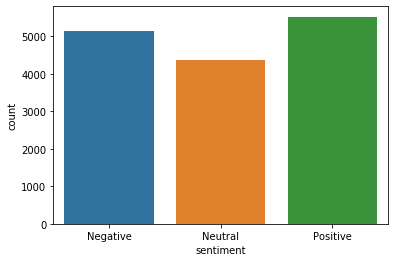

In [84]:
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score_df['val']), orient = 'index').reset_index()
sent_count.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_count)